In [1]:
%load_ext autoreload
%autoreload 2

import torch

from text3d2video.utilities.ipython_utils import display_ims
from text3d2video.pipelines.pipeline_utils import load_pipeline
from text3d2video.pipelines.texgen_pipeline import TexGenConfig, TexGenPipeline
from diffusers.schedulers import DDIMScheduler

torch.set_grad_enabled(False)

In [2]:

device = torch.device("cuda")
dtype = torch.float16
sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
pipe = load_pipeline(TexGenPipeline, sd_repo, controlnet_repo, DDIMScheduler)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
from text3d2video.util import read_obj_with_uvs
from text3d2video.utilities.camera_placement import (
    cam_view_prompt,
    turntable_extrinsics,
)
from pytorch3d.renderer import FoVPerspectiveCameras

mesh_path = "data/meshes/mixamo-human.obj"
device = "cuda"

# read mesh
mesh, verts_uvs, faces_uvs = read_obj_with_uvs(mesh_path, device=device)

n_frames = 10
dist = 5.8

angles = torch.linspace(0, 360, n_frames)
R, T = turntable_extrinsics(dists=dist, angles=angles)
frame_cams = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=10)

prompt_suffixes = [f", {cam_view_prompt(a, 0)} view" for a in angles]
frame_meshes = mesh.extend(len(frame_cams))

In [5]:
from text3d2video.rendering import render_rgb_uv_map
from text3d2video.utilities.ipython_utils import display_vid
from text3d2video.utilities.video_comparison import add_title_to_clip
from text3d2video.utilities.video_util import pil_frames_to_clip

prompt = "Deadpool"
uvs = render_rgb_uv_map(frame_meshes, frame_cams, verts_uvs, faces_uvs)

vid = add_title_to_clip(pil_frames_to_clip(uvs), f'"{prompt}"')
display_vid(vid)

In [12]:
from pathlib import Path
from text3d2video.utilities.logging import H5Logger

module_paths = [
    # "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

texgen_config = TexGenConfig(
    num_inference_steps=10,
    guidance_scale=7.5,
    controlnet_conditioning_scale=0.8,
    module_paths=module_paths,
    quality_update_factor=1.5,
    uv_res=600
)

generator = torch.Generator(device="cuda")
generator.manual_seed(1)

logger = H5Logger(Path("texgen_data.h5"))
logger.delete_data()
logger.open_write()
logger.enabled = True

images = pipe(
    prompt,
    frame_meshes,
    frame_cams,
    verts_uvs,
    faces_uvs,
    texgen_config=texgen_config,
    generator=generator,
    prompt_suffixes=prompt_suffixes,
    logger=logger,
)

# logger.close()

100%|██████████| 10/10 [00:32<00:00,  3.29s/it]


In [ ]:
from text3d2video.utilities.ipython_utils import display_vid
from text3d2video.utilities.video_util import pil_frames_to_clip

display_vid(pil_frames_to_clip(images))

: 

In [25]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact


anim = AnimationArtifact.from_wandb_artifact_tag('rumba:latest')

# Reading logged data

In [26]:
logger.open_read()

ts = sorted(logger.key_values("denoised_rgb", "t"), reverse=True)
frames = sorted(logger.key_values("denoised_rgb", "frame_i"))

KeyError: "Unable to synchronously open object (object 'denoised_rgb' doesn't exist)"

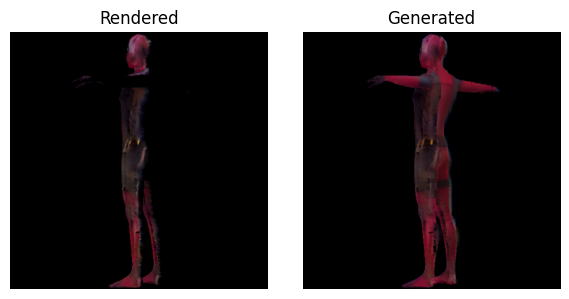

In [8]:
import torchvision.transforms.functional as TF

t = ts[9]
frame_i = frames[3]
kwargs = dict(t=t, frame_i=frame_i)

# get rendered clean image
rendered = logger.read("rendered_clean", **kwargs)

denoised_rgb = logger.read("denoised_rgb", **kwargs)

display_ims(
    [TF.to_pil_image(x) for x in [rendered, denoised_rgb]],
    titles=["Rendered", "Generated"],
    scale=3,
)

# TF.to_pil_image(rendered)
# pil_latent(rendered_latent)
# pil_latent(rendered_noisy)
# pil_latent(latent)
# pil_latent(blended_latent)
# pil_latent(denoised)
# TF.to_pil_image(denoised_rgb)
# TF.to_pil_image(rearrange(clean_tex, "h w c -> c h w"))

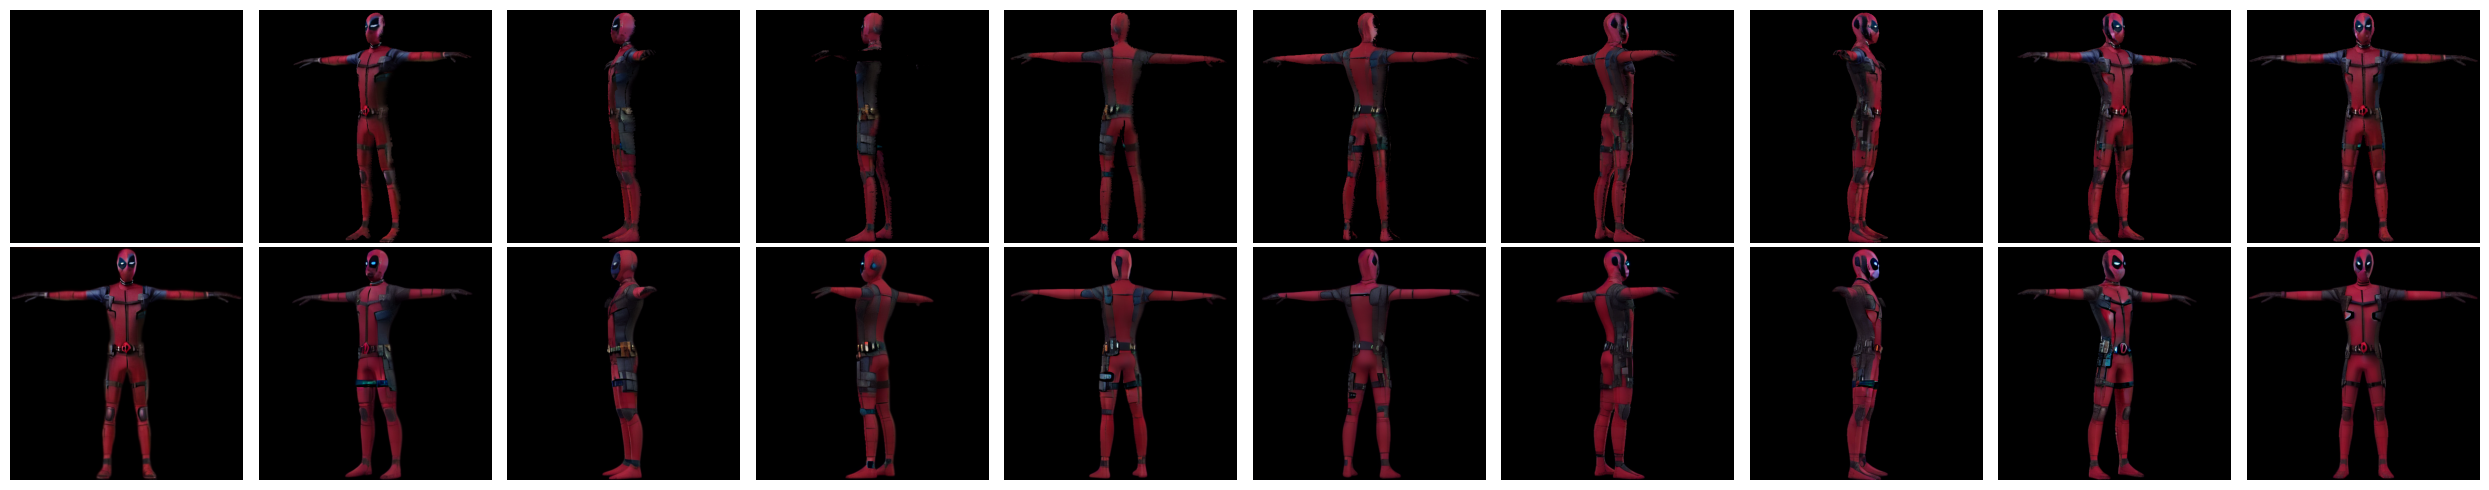

In [15]:
import torchvision.transforms.functional as TF

from text3d2video.utilities.ipython_utils import display_ims_grid

t = ts[7]

rendered_ims = []
denoised_ims= []
for f in frames:
    rendered = logger.read("rendered_clean", t=t, frame_i=f)
    denoised = logger.read("denoised_rgb", t=t, frame_i=f)
    rendered_ims.append(TF.to_pil_image(rendered))
    denoised_ims.append(TF.to_pil_image(denoised))

display_ims_grid([rendered_ims, denoised_ims])